Team Members: Navya sri Kalli, Kuldeep Prasad, Hemani Shah, Rohit Raj

Steps implemented


* Importing necessary libraries

* Preprocessing players_19 data

* Forming  X and y of players_19 dataset

* Implementing Neural Networks

* Preprocessing players_20 dataset

* Creating test set from players_20 dataset

* Predicting and computing the results



## **Importing necessary libraries**

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session()  # For easy reset of notebook state.


In [2]:
# Pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3


In [3]:
# Run this cell for more readable visuals 
large = 22; med = 16; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'axes.linewidth': 2,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.style.use('seaborn-whitegrid')
plt.rcParams.update(params)
%matplotlib inline

## **Preprocessing**

In [4]:
def pre_process_dataset(filename, train,Scaler):
    #Reading the data
    df=pd.read_csv(filename)
    df_club=df.club

    #Remove the last 31 columns 
    df = df.iloc[: , :-31]

    # Remove the columns suggested in the project description
    df.drop(["sofifa_id", "player_url", "short_name","long_name", "real_face", "potential"],axis=1,inplace=True)

    # Remove the columns that should not make a difference
    df.drop(["dob", "nationality", "club", "player_positions", "body_type", "loaned_from", "joined", "contract_valid_until"],axis=1,inplace=True)

    # Removing the columns for team_jersey_number and nation_jersey_number. These should not make a difference
    df.drop(["player_tags", "team_jersey_number", "nation_jersey_number"],axis=1,inplace=True)

    #dropping rows of players which do not have a team_position
    na = pd.notnull(df["team_position"])
    #print(sum(na))
    df = df[na]

    # Filling the NaN values with 0 in position specific columns
    for i in df.columns[14:26]:
        print("filling missing values in :"+i)
        df[i]=df[i].fillna(0)
    print()

    # Using the eval function on the columns which have expressions as values
    for i in df.columns[27:]:
        print("evaluating values in column :"+i)
        df[i]=df[i].apply(lambda x: eval(x) if isinstance(x,str) else x)
    print()

    df["preferred_foot"] = df["preferred_foot"].map({"Left":0, 'Right':1})
    df["release_clause_eur"].fillna(0.0, inplace=True)
    df["nation_position"]= df["nation_position"].apply(lambda x:0 if x == np.nan else 1)

    # Encoding Qualitative Attributes
    df["team_position"].replace('RES', 'GK', inplace=True)
    df["team_position"].replace('SUB', 'GK', inplace=True)
    #print(df.team_position.unique())
    df_encoded_team=pd.get_dummies(df["team_position"],prefix="team",drop_first=False)
    df=pd.concat([df,df_encoded_team],axis=1)
    df.drop(["team_position"],axis=1,inplace=True)

    #Each work rate column has two values for attacking and defending 
    # One hot encoding work_rate_att and work_rate_def
    df["work_rate_att"]=df["work_rate"].apply(lambda x: x.split("/")[0])
    df["work_rate_def"]=df["work_rate"].apply(lambda x: x.split("/")[1])
    df_att=pd.get_dummies(df["work_rate_att"],prefix="work_rate_att",drop_first=False)
    df_def=pd.get_dummies(df["work_rate_def"],prefix="work_rate_def",drop_first=False)
    df=pd.concat([df,df_att,df_def],axis=1)
    df.drop(["work_rate", "work_rate_att", "work_rate_def"],axis=1,inplace=True)

    # Replacing the traits values with the number of traits a player has
    # For Example if a player has two traits it will be replaced by 2
    df["player_traits"].fillna('', inplace=True)
    for i in range(df.shape[0]):
        a=df["player_traits"].iloc[i]
        b=len(a.split(','))
        if a=='':
            b=0
        df["player_traits"].iloc[i]=b

    # Converting all the columns to type integer
    for i in df.columns:
        print('converting '+i)
        df[i] = df[i].apply(pd.to_numeric)

    df.reset_index(drop=True, inplace=True)
    
    #Filtering the rows for test dataset
    if (not train):
        club_names = ['FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City','Liverpool FC']
        df=df[df_club.isin(club_names)]

    # Removing the columns which are not required to be standandardized
    cols = list(df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('preferred_foot')) #Remove b from list
    cols.pop(cols.index('overall')) #Remove x from list
    df = df[cols+['preferred_foot','overall']] 
    cols = list(df.columns.values)

    # Transforming the testing data and fit_transforming the training data
    df_ns = df.iloc[: , 52:].values
    df_s= df.iloc[: , :52].values

    if (train):
        df_s = Scaler.fit_transform(df_s)
    else:
        df_s = Scaler.transform(df_s)

    # Concatinating the dataframe with the scaled dataframe and not scaled dataframe
    df=pd.concat([pd.DataFrame(df_s), pd.DataFrame(df_ns)],axis=1)
    df.columns = cols
    return df,Scaler

## **Forming X and y of players_19 dataset**

In [5]:
Scaler = StandardScaler()
df,Scaler = pre_process_dataset("https://raw.githubusercontent.com/rraj29/data/main/players_19.csv", train=True,Scaler=Scaler)
# Get all the columns except 'sales' as the predictors
X = df.drop(['overall'],axis=1).values

# Select 'sales' as the response variable
y = df[['overall']].values
print(X.shape, y.shape)

## **Implementing neural network**

In [6]:
model = tf.keras.models.Sequential(name='MLP')
print(type(model))
model.add(layers.Dense(20, input_dim=X.shape[1], activation = 'relu', name='hidden_1'))
model.add(layers.Dense(10, activation = 'relu', name='hidden_2'))
model.add(layers.Dense(10, activation = 'relu', name='hidden_3'))
model.add(layers.Dense(10, activation = 'relu', name='hidden_4'))
#model.add(layers.Dense(5, activation = 'relu', name='hidden_5'))
#model.add(layers.Dense(20, activation = 'relu', name='hidden_6'))

model.add(layers.Dense(1, activation = 'linear', name='output'))
model.summary()

<class 'keras.engine.sequential.Sequential'>
Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 20)                1740      
_________________________________________________________________
hidden_2 (Dense)             (None, 10)                210       
_________________________________________________________________
hidden_3 (Dense)             (None, 10)                110       
_________________________________________________________________
hidden_4 (Dense)             (None, 10)                110       
_________________________________________________________________
output (Dense)               (None, 1)                 11        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


2021-10-30 05:02:32.976285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-30 05:02:32.976648: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
#Adding optimiser to the network
opt= keras.optimizers.Adam(
   learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
)

model.compile(optimizer=opt,
              loss='mse', 
              metrics=['mae'])

In [8]:
#Fitting the model with the data
history = model.fit(X, y, epochs = 50, validation_split=0.2, batch_size = 16, verbose=1)
history.history.keys()

2021-10-30 05:02:33.047861: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
878/878 [==============================] - 1s 932us/step - loss: 111.4800 - mae: 4.0781 - val_loss: 12.3796 - val_mae: 2.6368
Epoch 2/50
878/878 [==============================] - 1s 963us/step - loss: 2.5519 - mae: 1.2139 - val_loss: 6.4018 - val_mae: 1.9419
Epoch 3/50
878/878 [==============================] - 1s 1ms/step - loss: 2.4516 - mae: 1.1796 - val_loss: 5.3825 - val_mae: 1.9364
Epoch 4/50
878/878 [==============================] - 1s 843us/step - loss: 2.2254 - mae: 1.1485 - val_loss: 1.8588 - val_mae: 1.0105
Epoch 5/50
878/878 [==============================] - 1s 919us/step - loss: 2.1664 - mae: 1.1164 - val_loss: 1.5007 - val_mae: 0.9107
Epoch 6/50
878/878 [==============================] - 1s 831us/step - loss: 2.4956 - mae: 1.2113 - val_loss: 1.7881 - val_mae: 0.9606
Epoch 7/50
878/878 [==============================] - 1s 1ms/step - loss: 1.5481 - mae: 0.9588 - val_loss: 2.4431 - val_mae: 1.2642
Epoch 8/50
878/878 [==============================] - 1s 810us/

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

Text(0.5, 0.98, 'MLP Training')

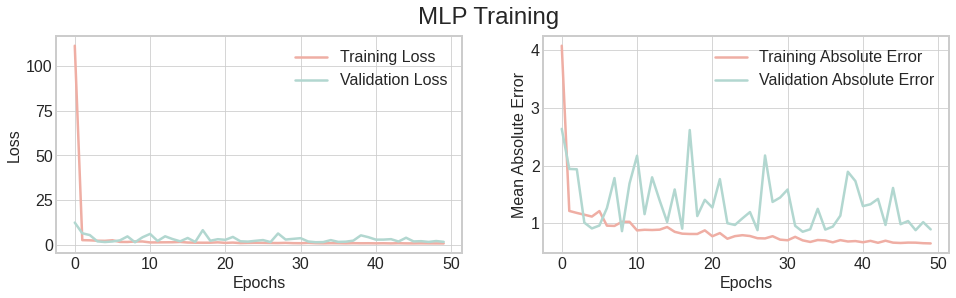

In [9]:
# Here we plot the training and validation loss and accuracy

fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],color='#EFAEA4',label = 'Training Loss', linewidth=2.5)
ax[0].plot(history.history['val_loss'],color='#B2D7D0',label = 'Validation Loss', linewidth=2.5)
ax[1].plot(history.history['mae'],color='#EFAEA4',label = 'Training Absolute Error', linewidth=2.5)
ax[1].plot(history.history['val_mae'],color='#B2D7D0',label = 'Validation Absolute Error', linewidth=2.5)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Mean Absolute Error');
fig.suptitle('MLP Training', fontsize = 24)

In [10]:
#printing the losses and accuracies of the model for training data
loss, accuracy = model.evaluate(X,y)

y_pred = model.predict(X)
R2_score = r2_score(y, y_pred)

print(f'Training Loss : {round(loss,4)}')
print(f'Training MAE : {round(accuracy,4)}')

print(f'R2 Score (Train set) : {round(R2_score,4)}')

549/549 [==============================] - 0s 517us/step - loss: 1.1061 - mae: 0.8489
Training Loss : 1.1061
Training MAE : 0.8489
R2 Score (Train set) : 0.9775


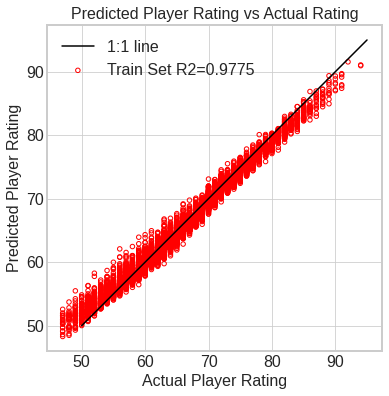

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y, y_pred, s=20, marker='o', c='None', edgecolors='red', label=f'Train Set R2={R2_score.round(4)}')
ax.set_xlabel("Actual Player Rating")
ax.set_ylabel("Predicted Player Rating")
ax.set_title("Predicted Player Rating vs Actual Rating")
ax.plot([50,95], [50,95], c='k', label="1:1 line")
ax.legend()

## **Creating test set from players_20 dataset**

In [12]:

df_test, Scaler = pre_process_dataset("https://raw.githubusercontent.com/rraj29/data/main/players_20.csv", train=False, Scaler=Scaler)

#Get all the columns except 'sales' as the predictors
X_test = df_test.drop(['overall'],axis=1).values

# Select 'sales' as the response variable
y_test = df_test[['overall']].values
print(X_test.shape, y_test.shape)

filling missing values in :pace
filling missing values in :shooting
filling missing values in :passing
filling missing values in :dribbling
filling missing values in :defending
filling missing values in :physic
filling missing values in :gk_diving
filling missing values in :gk_handling
filling missing values in :gk_kicking
filling missing values in :gk_reflexes
filling missing values in :gk_speed
filling missing values in :gk_positioning

evaluating values in column :attacking_crossing
evaluating values in column :attacking_finishing
evaluating values in column :attacking_heading_accuracy
evaluating values in column :attacking_short_passing
evaluating values in column :attacking_volleys
evaluating values in column :skill_dribbling
evaluating values in column :skill_curve
evaluating values in column :skill_fk_accuracy
evaluating values in column :skill_long_passing
evaluating values in column :skill_ball_control
evaluating values in column :movement_acceleration
evaluating values in col

/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_80/1895168019.py:76: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df[df_club.isin(club_names)]


## **Predicting and computing the results**

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

y_test_pred = model.predict(X_test)
R2_score_test = r2_score(y_test, y_test_pred)

print(f'Test Losss : {round(test_loss,4)}')
print(f'Test MAE : {round(test_accuracy,4)}')

print(f'R2 Score (Test set) : {round(R2_score_test,4)}')


6/6 [==============================] - 0s 3ms/step - loss: 2.7109 - mae: 1.4079
Test Losss : 2.7109
Test MAE : 1.4079
R2 Score (Test set) : 0.9671


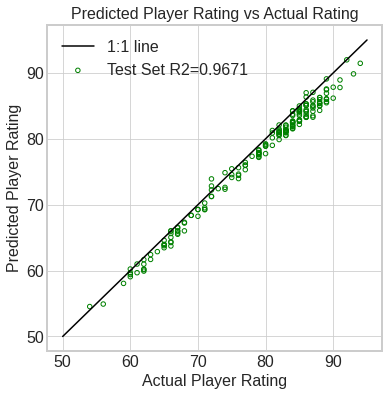

In [14]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(y_test, y_test_pred, s=20, marker='o', c='None', edgecolors='green', label=f'Test Set R2={R2_score_test.round(4)}')
ax.set_xlabel("Actual Player Rating")
ax.set_ylabel("Predicted Player Rating")
ax.set_title("Predicted Player Rating vs Actual Rating")
ax.plot([50,95], [50,95], c='k', label="1:1 line")
ax.legend()

In [15]:
max_overall_value=max(y_test_pred)
best_player_index=np.where(y_test_pred == max_overall_value)
print(f'The best player has an overall score of {max_overall_value[0]:2f} at an index of {best_player_index[0][0]}')

The best player has an overall score of 91.987015 at an index of 2


In [17]:
df_ans=pd.read_csv("https://raw.githubusercontent.com/rraj29/data/main/players_20.csv")


In [18]:
print(f"The best player is {df_ans['short_name'][:best_player_index[0][0]+1][0]}")

The best player is L. Messi
